In [1]:
#=== Installs and imports ===#
import pipeline_utils
import os
import gzip
import requests

## 
import pandas as pd

##


In [2]:

#=== ===#
# Note, proximity is measured by 
def identify_converging_genes(fasta_url, gff3_url, output_dir, gene_proximity = 1000, verbose=True):

    ##
    import pipeline_utils

    ## Log the function and params
    if verbose:
        print("Called identify_converging_genes function")
        print(f"Target fasta url: {fasta_url}")
        print(f"Target gff3 url: {gff3_url}")
        print(f"Output directory for genome files: {output_dir}")
        print(f"Minimum distance between gene pairs: {gene_proximity}")

    ## Instantiate the dataframe
    df_gene = pd.DataFrame(columns=["gene", "chromosome", "start", "end", "strand"])

    ## Download the required files, skip if already present
    os.makedirs(output_dir, exist_ok=True)
    fasta_path = os.path.join(output_dir, os.path.basename(fasta_url))
    gff3_path = os.path.join(output_dir, os.path.basename(gff3_url))

    ##
    if verbose:
        print(f"Destination filepath for fasta: {fasta_path}")
        print(f"Destination filepath for gff3: {gff3_path}")

    ## Download the required genome and annotation files ##
    if verbose:
        print("Attempting file downloads")
    ##
    pipeline_utils.download_file(fasta_url, fasta_path)
    pipeline_utils.download_file(gff3_url, gff3_path)


In [3]:
##
fasta_url = "http://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz"
gff3_url = "http://ftp.ensembl.org/pub/release-111/gff3/homo_sapiens/Homo_sapiens.GRCh38.111.gff3.gz"
output_dir = "../0.local/generic-single-cell-pipeline/genome_data"
max_proximity_bp = 1000

##
identify_converging_genes(fasta_url = fasta_url, gff3_url = gff3_url, output_dir = output_dir)

Called identify_converging_genes function
Target fasta url: http://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
Target gff3 url: http://ftp.ensembl.org/pub/release-111/gff3/homo_sapiens/Homo_sapiens.GRCh38.111.gff3.gz
Output directory for genome files: ../0.local/generic-single-cell-pipeline/genome_data
Minimum distance between gene pairs: 1000
Destination filepath for fasta: ../0.local/generic-single-cell-pipeline/genome_data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
Destination filepath for gff3: http://ftp.ensembl.org/pub/release-111/gff3/homo_sapiens/Homo_sapiens.GRCh38.111.gff3.gz
Attempting file downloads
Called download_file function
Target url: http://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
Destination filepath: ../0.local/generic-single-cell-pipeline/genome_data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
File already exists, exiting
Called download_fi

In [ ]:
####
gff3_path = "../0.local/generic-single-cell-pipeline/genome_data/Homo_sapiens.GRCh38.111.gff3/small_gff.txt.gz"
#genes = parse_gff3_genes(gff3_path)
#print(f"Parsed {len(genes)} genes.")


#=== PARSE GFF3 File ===#
def parse_gff3_genes(gff3_path, verbose = False):

    ##
    genes = pd.DataFrame(columns = ["id", "gene", "chrom", "source", "feature", "start", "end", "score", "strand", "phase"])
    temp_data = []

    ##
    with gzip.open(gff3_path, 'rt') as f:
    
        ##
        for line in f:
            ##
            if line.startswith("#"):
                if verbose:
                    print("Skipping line starting with ##")
                continue
    
            ##
            fields = line.strip().split("\t")
            print(f"Current fields: {fields}")
    
            ##
            if len(fields) < 9:
                if verbose:
                    print("Incomplete record, skipping")
                continue
    
            ##
            chrom, source, feature, start, end, score, strand, phase, attributes = fields
            
            if feature != "gene":
                if verbose:
                    print("Feature is not gene, skipping")
                continue
    
            ##
            attr_dict = {kv.split("=")[0]: kv.split("=")[1] for kv in attributes.split(";") if "=" in kv}
            gene_ID = attr_dict.get("ID", "unknown")
            gene_name = attr_dict.get("Name", "unknown")

            ##
            temp_data[0] = gene_ID, gene_name, chrom, source, feature, start, end, score, strand, phase
            
            ## append data to the dataframe
            genes.concat([genes, temp_data], ignore_index=True

 

In [ ]:
   
####
with gzip.open(gff3_path, 'rt') as f:

    ##
    for line in f:
        ##
        if line.startswith("#"):
            print("Skipping line starting with ##")
            continue

        ##
        fields = line.strip().split("\t")
        print(f"Current fields: {fields}")

        ##
        if len(fields) < 9:
            print("Incomplete record, skipping")
            continue

        ##
        chrom, source, feature, start, end, score, strand, phase, attributes = fields
        
        if feature != "gene":
            print("Feature is not gene, skipping")
            continue

        ##
        attr_dict = {kv.split("=")[0]: kv.split("=")[1] for kv in attributes.split(";") if "=" in kv}
        gene_ID = attr_dict.get("ID", "unknown")
        gene_name = attr_dict.get("Name", "unknown")

        ## append data to the dataframe
        genes.loc[len(genes)] = [gene_ID, gene_name, chrom, source, feature, start, end, score, strand, phase]

In [ ]:
    

####
with gzip.open(gff3_path, 'rt') as f:

    ##
    for line in f:
        ##
        if line.startswith("#"):
            print("Skipping line starting with ##")
            continue

        ##
        fields = line.strip().split("\t")
        print(f"Current fields: {fields}")

        ##
        if len(fields) < 9:
            print("Incomplete record, skipping")
            continue

        ##
        chrom, source, feature, start, end, score, strand, phase, attributes = fields
        
        if feature != "gene":
            print("Feature is not gene, skipping")
            continue

        ##
        attr_dict = {kv.split("=")[0]: kv.split("=")[1] for kv in attributes.split(";") if "=" in kv}
        gene_ID = attr_dict.get("ID", "unknown")
        gene_name = attr_dict.get("Name", "unknown")

        ## append data to the dataframe
        genes.loc[len(genes)] = [gene_ID, gene_name, chrom, source, feature, start, end, score, strand, phase]
    
    return genes





####
genes

In [ ]:



# --- FIND CLOSE OPPOSITE GENE PAIRS ---
def find_facing_gene_pairs(genes, max_distance):
    genes_by_chrom = {}
    for gene in genes:
        genes_by_chrom.setdefault(gene.chrom, []).append(gene)

    close_pairs = []
    for chrom, chrom_genes in genes_by_chrom.items():
        sorted_genes = sorted(chrom_genes, key=lambda g: g.start)
        for i in range(len(sorted_genes) - 1):
            g1 = sorted_genes[i]
            g2 = sorted_genes[i + 1]
            distance = g2.start - g1.end
            if 0 <= distance <= max_distance:
                # Check if they face each other
                if g1.strand == '+' and g2.strand == '-':
                    close_pairs.append((g1, g2))
                elif g1.strand == '-' and g2.strand == '+':
                    close_pairs.append((g2, g1))
    return close_pairs

facing_pairs = find_facing_gene_pairs(genes, max_proximity_bp)
print(f"Found {len(facing_pairs)} facing gene pairs within {max_proximity_bp} bp.")

# --- OUTPUT RESULTS ---
for g1, g2 in facing_pairs:
    print(f"{g1.name} ({g1.chrom}:{g1.start}-{g1.end} {g1.strand}) ↔ {g2.name} ({g2.chrom}:{g2.start}-{g2.end} {g2.strand})")

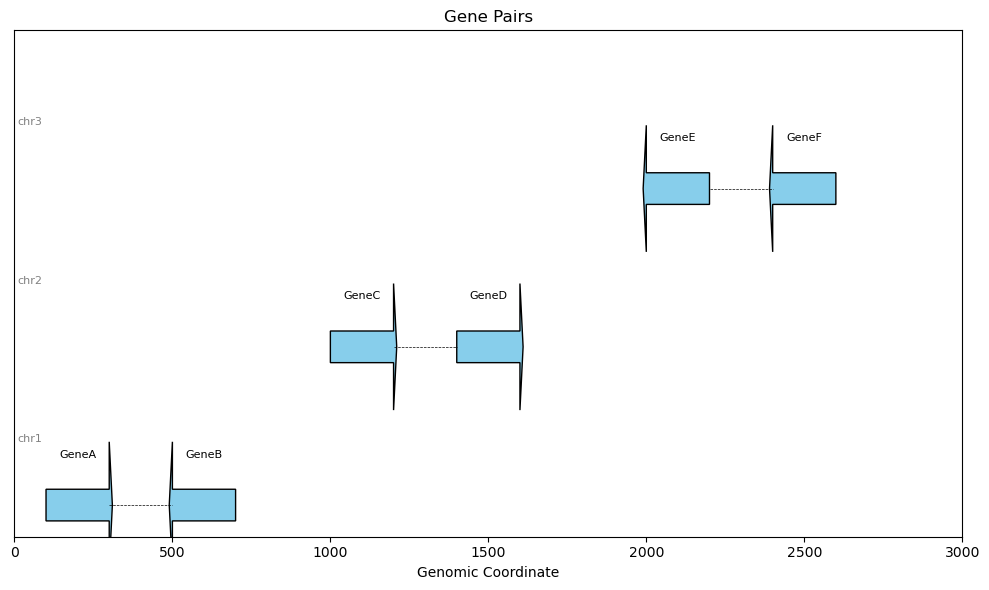

In [5]:


gene_pairs = [
    # (gene1_name, chr1, start1, end1, strand1, gene2_name, chr2, start2, end2, strand2)
    ("GeneA", "chr1", 100, 300, "+", "GeneB", "chr1", 500, 700, "-"),
    ("GeneC", "chr2", 1000, 1200, "+", "GeneD", "chr2", 1400, 1600, "+"),
    ("GeneE", "chr3", 2000, 2200, "-", "GeneF", "chr3", 2400, 2600, "-"),
]

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Sample input
gene_pairs = [
    ("GeneA", "chr1", 100, 300, "+", "GeneB", "chr1", 500, 700, "-"),
    ("GeneC", "chr2", 1000, 1200, "+", "GeneD", "chr2", 1400, 1600, "+"),
    ("GeneE", "chr3", 2000, 2200, "-", "GeneF", "chr3", 2400, 2600, "-"),
]

def plot_gene(ax, name, start, end, strand, y, color="skyblue"):
    width = end - start
    arrowprops = dict(facecolor=color, edgecolor="black", width=1, head_width=4, head_length=10)
    if strand == "+":
        ax.add_patch(patches.FancyArrow(start, y, width, 0, **arrowprops))
    else:
        ax.add_patch(patches.FancyArrow(end, y, -width, 0, **arrowprops))
    ax.text((start + end) / 2, y + 1.5, name, ha="center", fontsize=8)

# Set up figure
fig, ax = plt.subplots(figsize=(10, len(gene_pairs)*2))
ax.set_xlim(0, 3000)  # Adjust based on max coordinate in your data
ax.set_ylim(-1, len(gene_pairs)*5)

# Draw each gene pair
for i, (g1, chr1, s1, e1, strand1, g2, chr2, s2, e2, strand2) in enumerate(gene_pairs):
    y = i * 5
    ax.text(10, y + 2, f"{chr1}", fontsize=8, ha="left", color="gray")
    plot_gene(ax, g1, s1, e1, strand1, y)
    plot_gene(ax, g2, s2, e2, strand2, y)
    ax.plot([e1, s2], [y, y], "k--", linewidth=0.5)  # optional dashed line between genes

# Formatting
ax.set_xlabel("Genomic Coordinate")
ax.set_yticks([])
ax.set_title("Gene Pairs")
plt.tight_layout()
plt.show()